# MODELO 2 - SABENDO GENERO DO FILME

# :)

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,               # DPI for high-quality PNG/JPEG
})

# Load the data

In [2]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

In [3]:
with open("data/data_ids.json") as f:
    ids = json.load(f)

max_movieId = max(ids["moviesIDs"].values())
max_userId = max(ids["userIDs"].values())

# Create a matrix of users and movies
base_matrix = np.zeros((max_movieId + 1, max_userId + 1))
base_matrix.shape

(9724, 610)

In [4]:
df_genre = pd.read_csv("data/movies.csv")

# Define functions

In [5]:
# Utility matrix and Binary matrix
from scipy.sparse import lil_matrix

def utility_matrix_AND_binary_matrix(dfTrain, zerosMatrix = base_matrix, jsonIds = ids):
    Y = lil_matrix(zerosMatrix.shape)  # Use sparse matrix format
    R = lil_matrix(zerosMatrix.shape)
    for i, row in dfTrain.iterrows():
        original_movieId, original_userId = int(row["movieId"]), int(row["userId"])
        movieId = jsonIds["moviesIDs"][str(original_movieId)]
        userId = jsonIds["userIDs"][str(original_userId)]
        Y[movieId, userId] = row["rating"]
        R[movieId, userId] = 1
    return Y, R

In [6]:
def cofiCostFunc_Xknown(params, X, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    """
        
    # Unfold the params
    Theta = params
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_Theta = Lambda/2 *np.sum(Theta**2)
    reg_J = J + reg_Theta
    
    # Compute gradient
    Theta_grad = (err*R).T @ X
    grad = Theta_grad
    
    # Compute regularized gradient
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = reg_Theta_grad
    
    return J, grad, reg_J, reg_grad

In [7]:
def gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    Theta = initial_parameters
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = Theta
        cost, Theta_grad = cofiCostFunc_Xknown(params, X, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        #Update trainable parameters X & Theta applying gradient descent method        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = Theta
    return paramsFinal , J_history

# Set model features: X (movies genres as features)

In [8]:
num_movies, num_users = base_matrix.shape

genres = df_genre["genres"].str.split("|").tolist()
genres = {genre: 0 for sublist in genres for genre in sublist}
# create X: movies features
X = np.zeros((num_movies, len(genres))) # 20 genres
for movie in ids["moviesIDs"]:
    movieId_matrix = ids["moviesIDs"][movie]
    genre_dict = genres.copy()
    genres_list = df_genre[df_genre["movieId"] == int(movie)]["genres"].str.split("|").tolist()[0]
    for genre in genres_list:
        genre_dict[genre] = 1 / len(genres_list)
    X[movieId_matrix] = list(genre_dict.values())

X.shape

(9724, 20)

# Start modelling

In [9]:
# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

# define the number of movies, users and features
num_movies, num_users = base_matrix.shape
num_features = 20

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
results_stored = {(0, 0.005): 0.9840711598039373,
 (0, 0.0005): 1.2788811778538607,
 (0, 0.001): 1.1127864772566063,
 (0, 0.0075): 5.601493940739115e+105,
 (5, 0.005): 1.5331568622653198,
 (5, 0.0005): 1.5859375620130582,
 (5, 0.001): 1.5396687638664905,
 (5, 0.0075): 4.364430499943079e+110,
 (10, 0.005): 1.8280749714092337,
 (10, 0.0005): 1.8380954108504541,
 (0, 0.0055): 0.9821569988696647,
 (5, 0.0055): 1.533156849580742,
 (10, 0.001): 1.8283913279304576,
 (1, 0.005): 1.1074223075018303,
 (3, 0.005): 1.355656539850337,
 (2, 0.005): 1.2427074684501644,
 (15, 0.005): 2.0214945932880273,
 (20, 0.005): 2.164069908617318,
 (0.1, 0.005): 0.989987655349287,
 (0.5, 0.005): 1.0351197733959776,
 (0, 0.002): 1.026453785975172,
 (0.1, 0.0005): 1.2836611866909944,
 (0.1, 0.001): 1.1189147974518,
 (0.1, 0.0055): 0.9876443635034207,
 (0.1, 0.002): 1.0331659544104292,
 (0.2, 0.005): 0.9986996157952619,
 (0.2, 0.0005): 1.2900517525794473,
 (0.2, 0.001): 1.1269235771152766,
 (0.2, 0.0055): 0.9960532840094553,
 (0.2, 0.002): 1.041783329785714,
 (1, 0.0005): 1.337174235983246,
 (1, 0.001): 1.1949946765986441,
 (1, 0.0055): 1.1069031715136974,
 (1, 0.002): 1.1293868381677885,
 (0.5, 0.0005): 1.3069111025875428,
 (0.5, 0.001): 1.1508983488512108,
 (0.5, 0.0055): 1.0336107573164997,
 (0.5, 0.002): 1.0711857501235909,
 (2, 0.0005): 1.4004237022020671,
 (2, 0.001): 1.2882144775452624,
 (2, 0.0055): 1.2426694222528734,
 (2, 0.002): 1.2493780409219197,
 (0.05, 0.005): 0.9861742442921604,
 (0.05, 0.0005): 1.2814398284137614,
 (0.05, 0.001): 1.1156459064276887,
 (0.05, 0.0055): 0.984353096458239,
 (0.05, 0.002): 1.0292129526552873}

In [11]:
Lambdas = [0, 0.1,0.2,1, 0.5, 2,0.05]
alphas = [0.005, 0.0005, 0.001, 0.0055, 0.002]
num_iters = 500

combo = 1
results = {}
for Lambda in Lambdas:
    for alpha in alphas:
        if (Lambda, alpha) in results_stored:
            print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):") 
            combo += 1
            continue
        
        print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):", end=" ") 
        combo += 1

        avg_RMSE = 0
        for exclude_index in range(8):
            merged_df = pd.concat([part for i, part in enumerate(folds) if i != exclude_index])

            # Create the utility matrix and the binary matrix
            Y, R = utility_matrix_AND_binary_matrix(merged_df)
            Y, R = Y.toarray(), R.toarray()

            # Define the initial parameters
            X = X
            Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
            initial_parameters = Theta

            # Apply gradient descent
            param, jhist = gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda)

            # Unfold the final parameters
            X = X
            Theta = param

            # Predict all ratings of num_users for num_movies
            p = X @ Theta.T

            # Compute the RMSE
            RMSE = 0
            for i, row in folds[exclude_index].iterrows():
                movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
                userId_matrix = ids["userIDs"][str(int(row["userId"]))]
                RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
            RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
            print(f"CV{exclude_index+1}: {RMSE:.1f}", end=", ")
            avg_RMSE += RMSE/8
        
        results[(Lambda, alpha)] = avg_RMSE
        print("")

Combination 1 of 35 with (0, 0.005):
Combination 2 of 35 with (0, 0.0005):
Combination 3 of 35 with (0, 0.001):
Combination 4 of 35 with (0, 0.0055):
Combination 5 of 35 with (0, 0.002):
Combination 6 of 35 with (0.1, 0.005):
Combination 7 of 35 with (0.1, 0.0005):
Combination 8 of 35 with (0.1, 0.001):
Combination 9 of 35 with (0.1, 0.0055):
Combination 10 of 35 with (0.1, 0.002):
Combination 11 of 35 with (0.2, 0.005):
Combination 12 of 35 with (0.2, 0.0005):
Combination 13 of 35 with (0.2, 0.001):
Combination 14 of 35 with (0.2, 0.0055):
Combination 15 of 35 with (0.2, 0.002):
Combination 16 of 35 with (1, 0.005):
Combination 17 of 35 with (1, 0.0005):
Combination 18 of 35 with (1, 0.001):
Combination 19 of 35 with (1, 0.0055):
Combination 20 of 35 with (1, 0.002):
Combination 21 of 35 with (0.5, 0.005):
Combination 22 of 35 with (0.5, 0.0005):
Combination 23 of 35 with (0.5, 0.001):
Combination 24 of 35 with (0.5, 0.0055):
Combination 25 of 35 with (0.5, 0.002):
Combination 26 of 3

In [12]:
results

{}

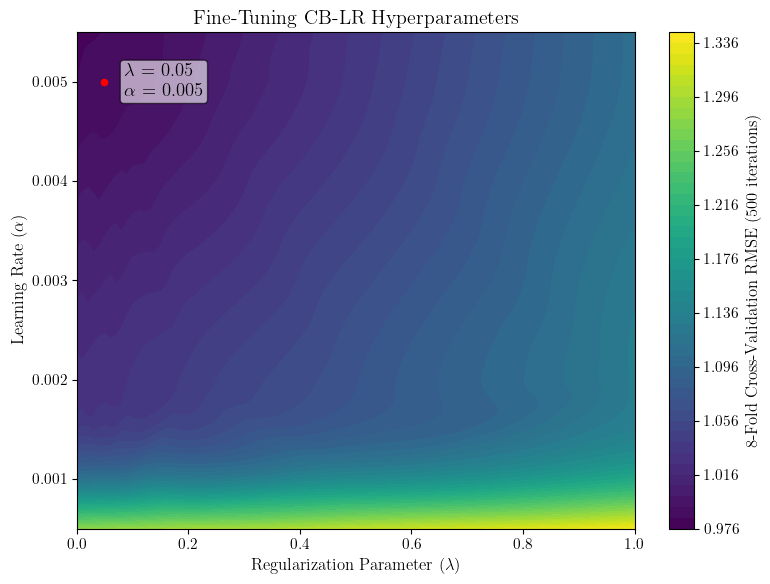

In [13]:
from scipy.interpolate import griddata

results = {x:y for x,y in results_stored.items() if x[1] < 0.007 and x[0] <2}
# Extract x, y, and z values
points = np.array(list(results.keys()))
x, y = points[:, 0], points[:, 1]
z = np.array(list(results.values()))

# Create a grid for interpolation
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100) #max()
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values onto the grid
zi = griddata(points, z, (xi, yi), method='cubic') #nearest, cubic, linear

# Plot the topographic map
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(contour, label='8-Fold Cross-Validation RMSE (500 iterations)')
best_lambda, best_alpha = (0.05, 0.005)
plt.scatter(best_lambda, best_alpha, color='red', s=20)
plt.text(
    best_lambda * 1.7, 
    best_alpha, 
    r"$\lambda$ = " + f"{best_lambda}\n" + r"$\alpha$ = " + str(best_alpha), 
    fontsize=13.5, 
    color='black',
    va = 'center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
)
plt.title('Fine-Tuning CB-LR Hyperparameters')
plt.xlabel(r'Regularization Parameter ($\lambda$)')
plt.ylabel(r'Learning Rate ($\alpha$)')
plt.tight_layout()
plt.savefig('assets/model02_hyperparemeterstunning.png')
plt.show()

In [14]:
# choose the best hyperparameters
best_lambda, best_alpha = (0.05, 0.005)
print(f"The best hyperparameters are: ({best_lambda}, {best_alpha}) with RMSE: {results_stored[(best_lambda, best_alpha)]:.5f}")

The best hyperparameters are: (0.05, 0.005) with RMSE: 0.98617


# Evaluate the optimized model

In [15]:
# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()

# Define the initial parameters
Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
initial_parameters = Theta

# Apply gradient descent
param, jhist = gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,best_alpha,750,best_lambda)

# Unfold the final parameters
X = X
Theta = param

# Predict all ratings of num_users for num_movies
p = X @ Theta.T

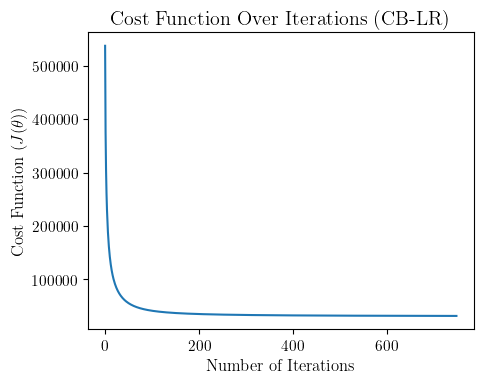

In [16]:
plt.plot(jhist)
plt.title("Cost Function Over Iterations (CB-LR)")
plt.xlabel("Number of Iterations")
plt.ylabel(r"Cost Function ($J(\theta)$)")
plt.tight_layout()
plt.savefig("assets/model02_cost_function.png")
plt.show()

In [17]:
df_to_evaluate = df_train
RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
RMSE = np.sqrt(RMSE/len(df_to_evaluate))
print(f"RMSE for train set: {RMSE:.5f}")

df_to_evaluate = df_test
RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
RMSE = np.sqrt(RMSE/len(df_to_evaluate))
print(f"RMSE for test set: {RMSE:.5f}")

RMSE for train set: 0.84863
RMSE for test set: 0.97240


In [18]:
df_to_evaluate = df_train
MAE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    MAE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])
MAE = MAE/len(df_to_evaluate)
print(f"MAE for train set: {MAE:.5f}")

df_to_evaluate = df_test
MAE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    MAE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])
MAE = MAE/len(df_to_evaluate)
print(f"MAE for train set: {MAE:.5f}")

MAE for train set: 0.66005
MAE for train set: 0.74607


In [19]:
"""# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()


# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

dict_RMSE = {}
for fold in range(8):
    merged_df = pd.concat([part for i, part in enumerate(folds) if i != fold])

    # Define the initial parameters
    X = X
    Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
    params = Theta
    for train_set_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        merged_df_sized = merged_df.sample(frac=train_set_size, random_state=42)

        Y, R = utility_matrix_AND_binary_matrix(merged_df_sized)
        Y, R = Y.toarray(), R.toarray()

        
    
        # Apply gradient descent
        param, jhist = gradientDescent_Xknown(params,X,Y,R,num_users,num_movies,num_features,best_alpha,750,best_lambda)

        # Unfold the final parameters
        X = X
        Theta = param

        # Predict all ratings of num_users for num_movies
        p = X @ Theta.T

        df_to_evaluate = folds[fold]
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, train_set_size, "test")] = RMSE

        df_to_evaluate = merged_df
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, train_set_size, "train")] = RMSE

        print(f"Fold {fold+1} with {train_set_size} in train_set_size: done")"""
"" # data saved as learning_curve_data

''

In [20]:
learning_curve_data = {(0, 0.1, 'test'): 1.53127765614101,
 (0, 0.1, 'train'): 1.492795353454827,
 (0, 0.2, 'test'): 1.2859622778419324,
 (0, 0.2, 'train'): 1.217465461187198,
 (0, 0.3, 'test'): 1.1733420788314464,
 (0, 0.3, 'train'): 1.0906314416958256,
 (0, 0.4, 'test'): 1.1069542350298458,
 (0, 0.4, 'train'): 1.0112306388410754,
 (0, 0.5, 'test'): 1.060931124863778,
 (0, 0.5, 'train'): 0.9592049314658372,
 (0, 0.6, 'test'): 1.0252008788651128,
 (0, 0.6, 'train'): 0.9225158837181894,
 (0, 0.7, 'test'): 1.0072500532930566,
 (0, 0.7, 'train'): 0.896668557991683,
 (0, 0.8, 'test'): 0.9901187543258922,
 (0, 0.8, 'train'): 0.8766831275295348,
 (0, 0.9, 'test'): 0.9769690422903031,
 (0, 0.9, 'train'): 0.8599592981352149,
 (0, 1.0, 'test'): 0.9681025208479292,
 (0, 1.0, 'train'): 0.847054604455713,
 (1, 0.1, 'test'): 1.5508547449272803,
 (1, 0.1, 'train'): 1.492219436882351,
 (1, 0.2, 'test'): 1.296127477436866,
 (1, 0.2, 'train'): 1.2160823856194773,
 (1, 0.3, 'test'): 1.178117176867599,
 (1, 0.3, 'train'): 1.0857600944703185,
 (1, 0.4, 'test'): 1.1140548729607034,
 (1, 0.4, 'train'): 1.0059880008992443,
 (1, 0.5, 'test'): 1.0702674976622932,
 (1, 0.5, 'train'): 0.9560900072545507,
 (1, 0.6, 'test'): 1.0413937849907593,
 (1, 0.6, 'train'): 0.9213650900893149,
 (1, 0.7, 'test'): 1.0216286586431607,
 (1, 0.7, 'train'): 0.8943299320117399,
 (1, 0.8, 'test'): 1.007460265463797,
 (1, 0.8, 'train'): 0.8739025606868156,
 (1, 0.9, 'test'): 0.9934389179699841,
 (1, 0.9, 'train'): 0.8578077771187346,
 (1, 1.0, 'test'): 0.9858015054905305,
 (1, 1.0, 'train'): 0.8451963935301586,
 (2, 0.1, 'test'): 1.5606750609673832,
 (2, 0.1, 'train'): 1.4992881205389168,
 (2, 0.2, 'test'): 1.2989617374349425,
 (2, 0.2, 'train'): 1.2150617357075815,
 (2, 0.3, 'test'): 1.1804064950900788,
 (2, 0.3, 'train'): 1.0874216118540818,
 (2, 0.4, 'test'): 1.110993203530357,
 (2, 0.4, 'train'): 1.0072309454058133,
 (2, 0.5, 'test'): 1.0709651795012887,
 (2, 0.5, 'train'): 0.9557959305727405,
 (2, 0.6, 'test'): 1.0496937439131697,
 (2, 0.6, 'train'): 0.9217134343830263,
 (2, 0.7, 'test'): 1.0294664214945848,
 (2, 0.7, 'train'): 0.8940531361184684,
 (2, 0.8, 'test'): 1.0108450225769219,
 (2, 0.8, 'train'): 0.8737319758134868,
 (2, 0.9, 'test'): 0.9958519240538349,
 (2, 0.9, 'train'): 0.8576320246931025,
 (2, 1.0, 'test'): 0.9870786463080197,
 (2, 1.0, 'train'): 0.8441405305463902,
 (3, 0.1, 'test'): 1.5450606285396478,
 (3, 0.1, 'train'): 1.5045144800767536,
 (3, 0.2, 'test'): 1.299923114313477,
 (3, 0.2, 'train'): 1.2177789258145972,
 (3, 0.3, 'test'): 1.1861031531950508,
 (3, 0.3, 'train'): 1.0904302230841243,
 (3, 0.4, 'test'): 1.1104122511893648,
 (3, 0.4, 'train'): 1.0077913931489069,
 (3, 0.5, 'test'): 1.068006997831624,
 (3, 0.5, 'train'): 0.958655500263749,
 (3, 0.6, 'test'): 1.0354020738109573,
 (3, 0.6, 'train'): 0.9234884178712919,
 (3, 0.7, 'test'): 1.013728710663743,
 (3, 0.7, 'train'): 0.8953893080932418,
 (3, 0.8, 'test'): 1.000488836192995,
 (3, 0.8, 'train'): 0.8762879625990898,
 (3, 0.9, 'test'): 0.9888156725654428,
 (3, 0.9, 'train'): 0.8601062855676483,
 (3, 1.0, 'test'): 0.9767180881004776,
 (3, 1.0, 'train'): 0.8459873997992015,
 (4, 0.1, 'test'): 1.5489484744464368,
 (4, 0.1, 'train'): 1.4921025782761985,
 (4, 0.2, 'test'): 1.2881067652035219,
 (4, 0.2, 'train'): 1.2081145730859892,
 (4, 0.3, 'test'): 1.1679910566692555,
 (4, 0.3, 'train'): 1.0804993191037457,
 (4, 0.4, 'test'): 1.0979092877374999,
 (4, 0.4, 'train'): 1.007408532341462,
 (4, 0.5, 'test'): 1.0592453962556458,
 (4, 0.5, 'train'): 0.9586421217991384,
 (4, 0.6, 'test'): 1.036085062151326,
 (4, 0.6, 'train'): 0.9223481495201314,
 (4, 0.7, 'test'): 1.0144719036480625,
 (4, 0.7, 'train'): 0.8976332789843016,
 (4, 0.8, 'test'): 1.0010578344753738,
 (4, 0.8, 'train'): 0.8762146158342411,
 (4, 0.9, 'test'): 0.9873659631515226,
 (4, 0.9, 'train'): 0.8597422099827043,
 (4, 1.0, 'test'): 0.9761516770910098,
 (4, 1.0, 'train'): 0.8451629700864527,
 (5, 0.1, 'test'): 1.5511292068375875,
 (5, 0.1, 'train'): 1.4873922972376854,
 (5, 0.2, 'test'): 1.2993676966279835,
 (5, 0.2, 'train'): 1.2125899045913842,
 (5, 0.3, 'test'): 1.1775918391625373,
 (5, 0.3, 'train'): 1.0777111798463594,
 (5, 0.4, 'test'): 1.113296218697666,
 (5, 0.4, 'train'): 1.004470361657755,
 (5, 0.5, 'test'): 1.0772507336391628,
 (5, 0.5, 'train'): 0.9561235751246856,
 (5, 0.6, 'test'): 1.041527198759212,
 (5, 0.6, 'train'): 0.9203187458791408,
 (5, 0.7, 'test'): 1.0239370164479271,
 (5, 0.7, 'train'): 0.8956923320667253,
 (5, 0.8, 'test'): 1.004940888892778,
 (5, 0.8, 'train'): 0.8747654914956143,
 (5, 0.9, 'test'): 0.9938309584783817,
 (5, 0.9, 'train'): 0.8588569641381977,
 (5, 1.0, 'test'): 0.9847877372593565,
 (5, 1.0, 'train'): 0.8453318726282865,
 (6, 0.1, 'test'): 1.5383629852880967,
 (6, 0.1, 'train'): 1.4857288439400151,
 (6, 0.2, 'test'): 1.265537885781064,
 (6, 0.2, 'train'): 1.2093522401953973,
 (6, 0.3, 'test'): 1.1609878387871622,
 (6, 0.3, 'train'): 1.0814942149316904,
 (6, 0.4, 'test'): 1.0915479728032766,
 (6, 0.4, 'train'): 1.0040010567827942,
 (6, 0.5, 'test'): 1.0550449538666602,
 (6, 0.5, 'train'): 0.9567274034476072,
 (6, 0.6, 'test'): 1.0272195329444294,
 (6, 0.6, 'train'): 0.9198139314430425,
 (6, 0.7, 'test'): 1.0086996780655186,
 (6, 0.7, 'train'): 0.8957226975302848,
 (6, 0.8, 'test'): 0.9944183458871884,
 (6, 0.8, 'train'): 0.87544134881401,
 (6, 0.9, 'test'): 0.9826158437839899,
 (6, 0.9, 'train'): 0.8594347186547312,
 (6, 1.0, 'test'): 0.9720211488838543,
 (6, 1.0, 'train'): 0.8458032294504997,
 (7, 0.1, 'test'): 1.5400718568014407,
 (7, 0.1, 'train'): 1.4835401539672899,
 (7, 0.2, 'test'): 1.2884753327111604,
 (7, 0.2, 'train'): 1.2064824395756226,
 (7, 0.3, 'test'): 1.1753861340917584,
 (7, 0.3, 'train'): 1.0760623087576882,
 (7, 0.4, 'test'): 1.101119198161465,
 (7, 0.4, 'train'): 0.9985176447060762,
 (7, 0.5, 'test'): 1.061120605893413,
 (7, 0.5, 'train'): 0.9529257655977127,
 (7, 0.6, 'test'): 1.0329619890769564,
 (7, 0.6, 'train'): 0.9157633099861477,
 (7, 0.7, 'test'): 1.018698809385401,
 (7, 0.7, 'train'): 0.8928021716929795,
 (7, 0.8, 'test'): 1.0038368706009577,
 (7, 0.8, 'train'): 0.8731683323435824,
 (7, 0.9, 'test'): 0.9946314535353381,
 (7, 0.9, 'train'): 0.8582139895895109,
 (7, 1.0, 'test'): 0.9832845286478705,
 (7, 1.0, 'train'): 0.8450095458798668}

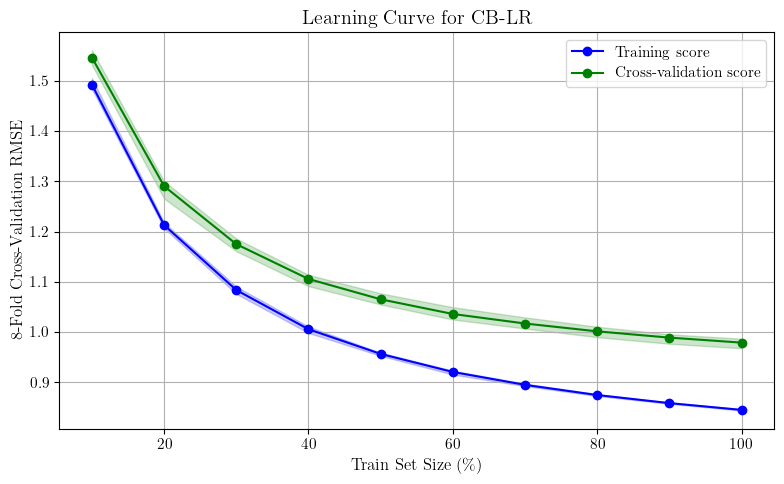

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

#data = dict_RMSE_stored_ITERATIONS
data = learning_curve_data


def plot_learning_curve(dataset):
    # Step 1: Group by j
    grouped_data = defaultdict(list)
    for (i, j, set), k in data.items():
        if set == dataset and j != 0:
            grouped_data[j].append(k)

    # Step 2: Calculate statistics
    mean_accuracy = []
    std_accuracy = []
    min_a = []
    max_a = []
    iterations = sorted(grouped_data.keys())  # Ensure ordered by j

    for j in iterations:
        values = grouped_data[j]
        mean_accuracy.append(np.mean(values))
        std_accuracy.append(np.std(values))
        min_a.append(np.min(values))
        max_a.append(np.max(values))

    # Step 3: Plot the curve with shaded area
    mean_accuracy = np.array(mean_accuracy)
    std_accuracy = np.array(std_accuracy)

    if dataset == "train":
        plt.plot(np.array(iterations)*100, mean_accuracy, "-o", label="Training score", color="blue")
        plt.fill_between(
            np.array(iterations)*100, 
            min_a, #mean_accuracy - std_accuracy, 
            max_a, #mean_accuracy + std_accuracy, 
            color="blue", alpha=0.2
        )
    else:
        plt.plot(np.array(iterations)*100, mean_accuracy, "-o", label="Cross-validation score", color="green")
        plt.fill_between(
            np.array(iterations)*100, 
            min_a, #mean_accuracy - std_accuracy, 
            max_a, #mean_accuracy + std_accuracy, 
            color="green", alpha=0.2
        )

plt.figure(figsize=(8, 5))
plot_learning_curve("train")
plot_learning_curve("test")

# Step 4: Add labels and legend
plt.xlabel(r"Train Set Size (\%)")
plt.ylabel("8-Fold Cross-Validation RMSE")
plt.title("Learning Curve for CB-LR")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("assets/model02_learning_curve.png")
plt.show()

## Saving the model

In [22]:
import json

"""with open("data/models.json", "r") as file:
    dicio_model = json.load(file)

dicio_model["model02"] = {"x": X.tolist(), "theta": Theta.tolist(), "lambda": best_lambda, "alpha": best_alpha, "iterations": 750}

with open("data/models.json", "w") as file:
    json.dump(dicio_model, file, indent=4)"""
#"" # dont store every run

'with open("data/models.json", "r") as file:\n    dicio_model = json.load(file)\n\ndicio_model["model02"] = {"x": X.tolist(), "theta": Theta.tolist(), "lambda": best_lambda, "alpha": best_alpha, "iterations": 750}\n\nwith open("data/models.json", "w") as file:\n    json.dump(dicio_model, file, indent=4)'

In [23]:
"""with open("data/models.json", "r") as file:
    dicio_model = json.load(file)

x = np.array(dicio_model["model02"]["x"])
theta = np.array(dicio_model["model02"]["theta"])

p = x @ theta.T"""
"" # test import the model

''